# Magics

In [1]:
%load_ext autoreload

%autoreload 2

# Imports

In [2]:
import os
import gc
import configparser
import pathlib as p
import numpy as np
import seaborn as sns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [4]:
import pandas as pd
pd.options.display.max_columns = 999

In [5]:
import torch

In [6]:
import clipper_python as clipper

In [7]:
import torch.nn as nn
import torch.optim as optim

In [8]:
from frag_nn.pytorch.network import GNINA_regressor, GNINA_regressor_v2, GNINA_regressor_v3, GNINA_regressor_v4, GNINA_regressor_v5, GNINA_regressor_v6, GNINA_regressor_v7, GNINA_regressor_v8
from frag_nn.data import XChemData
from frag_nn.pytorch.network import ClassifierV3
from frag_nn.pytorch.dataset import EventDataset
from frag_nn.pytorch.dataset import OrthogonalGrid
from frag_nn.pytorch.dataset import GetRandomisedLocation, GetRandomisedRotation
from frag_nn.pytorch.dataset import GetAnnotationClassifier, GetDataRefMoveZ

from frag_nn.pytorch.dataset import XChemDataset
import frag_nn.constants as c


# Get Config

In [9]:
config_path = "/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini"

In [10]:
conf = configparser.ConfigParser()

In [11]:
conf.read(config_path)

['/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini']

In [12]:
ds_conf = conf[c.x_chem_database]

In [13]:
grid_size = 48
grid_step = 0.5


In [14]:
network_type = "classifier"
network_version = 3
dataset_version = 3
train = "cluster"
transforms = "rottrans"

In [15]:
state_dict_dir = "/dls/science/groups/i04-1/conor_dev/pandda_nn/"
state_dict_file = state_dict_dir + "model_params_{}_{}_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                                                  grid_step,
                                                                                  network_type,
                                                                                  network_version,
                                                                                  dataset_version,
                                                                                  train,
                                                                                  transforms)

# Load Database

In [16]:
x_chem_dataset = XChemData(host=ds_conf[c.db_host], 
                         port=ds_conf[c.db_port], 
                         database=ds_conf[c.db_database], 
                         user=ds_conf[c.db_user], 
                         password=ds_conf[c.db_password])


In [17]:
events = x_chem_dataset.get_database("pandda_event")

# Get accessible events

In [18]:
accessible_events_list = []

for pth in events["pandda_input_mtz"]:
    try:
        if p.Path(pth).exists():
            accessible_events_list.append(True)
        else:
            accessible_events_list.append(False)
            
    except PermissionError as e:
        accessible_events_list.append(False)


In [19]:
accessible_events_mask = np.array(accessible_events_list)

In [20]:
accessible_events = events[accessible_events_mask]

In [21]:
split = np.random.rand(len(accessible_events)) < 0.9

In [22]:
events_train = accessible_events[split]#
print(len(events_train))

1675


In [23]:
events_test = accessible_events[~split]
print(len(events_test))

194


In [24]:
events_train = pd.read_csv("new_events_train.csv")

/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
events_test = pd.read_csv("new_events_test.csv")

# Create Dataset

In [26]:
# dataset_train = XChemDataset(events_train,
#                               mode="RefMovev2",
#                  grid_size=grid_size,
#                  grid_step=grid_step,
#                             replace_rate=1.0)

In [27]:
grid= OrthogonalGrid(grid_size, 
                     grid_step)

In [28]:
test_dataset = EventDataset(events=events_test,
                             transforms_record=[GetRandomisedLocation(base_trans_max=4.0, secondary_trans_max=0.0),
                                                    GetRandomisedRotation(max_rot=0.0)],
                             get_annotation=GetAnnotationClassifier(),
                             get_data=GetDataRefMoveZ(grid)
                            )

In [29]:
sample = test_dataset[np.random.randint(len(test_dataset))]

In [30]:
x = sample["data"]

In [31]:
x.shape

(3, 48, 48, 48)

In [32]:
x_t = torch.Tensor(x)

In [33]:
x_t = x_t.unsqueeze(0)

In [34]:
x_t.shape

torch.Size([1, 3, 48, 48, 48])

In [35]:
sample["annotation"]

array([1., 0.], dtype=float32)

In [36]:
# model(x_t)

In [37]:
# x = dataset_train[10]["x"]

In [38]:
# x_2 = dataset_train[10]["x"]

In [39]:
# x_np_slice_2d = x[:, :, int(x.shape[2]/2)]

In [40]:
# x_np_slice_2d_2 = x_2[:, :, int(x.shape[2]/2)]

In [41]:
# plt.imshow(x_np_slice_2d)

In [42]:
# plt.imshow(x_np_slice_2d_2)

# Create Dataloaders

In [43]:
# train_dataloader = torch.utils.data.DataLoader(dataset_train,
#                                          batch_size=10, 
#                                          shuffle=True,
#                                          num_workers=10)

In [44]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=10, 
                                         shuffle=True,
                                         num_workers=10)

# Define Model

In [45]:
model = ClassifierV3(32,
                        grid_dimension=grid_size)

In [46]:
model.load_state_dict(torch.load(state_dict_file))

In [47]:
print(model)

ClassifierV3(
  (conv_1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(9, 9, 9), stride=(1, 1, 1), padding=(4, 4, 4))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_1): ResidualLayerWithDrop(
    (conv_1): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (res_1): ResidualBlock(
      (conv_1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (drop): Dropout3d(p=0.1)
    (mp): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (act): ReLU()
  )
  (layer_2): ResidualLayerWithDrop(
    (conv_1): 

# Define loss function

In [48]:
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

# Precision - Recall functions

In [49]:
def get_precision(y_hat, y, cutoff):
    
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)
    
    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_positives = np.count_nonzero(positives_hat_mask[negatives_mask])
    
    total_predicted_positives = true_positives + false_positives
    
    if total_predicted_positives == 0:
        return 1
    
    precision = true_positives / total_predicted_positives
    
    return precision


In [50]:
def get_recall(y_hat, y, cutoff):
    positives_hat_mask = (y_hat > cutoff)
    negatives_hat_mask = (y_hat <= cutoff)

    positives_mask = (y == 1)
    negatives_mask = (y == 0)

    true_positives = np.count_nonzero(positives_hat_mask[positives_mask])
    false_negatives = np.count_nonzero(negatives_hat_mask[positives_mask])    

    total_positives = (true_positives + false_negatives)
    
    if total_positives == 0:
        return 0
    
    recall = true_positives / total_positives

    return recall

# Evaluate - Test Data

In [51]:
y_test = []
y_test_hat = []

In [52]:
for i, data in enumerate(test_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["data"]
    y = data["annotation"]
#     x = x.unsqueeze(1)
    y = y.view(-1,2)
    
    outputs = model(x)
    
    y_test.append(y.detach())
    y_test_hat.append(outputs.detach())
#     optimizer.zero_grad()
    gc.collect()

Iteration: 0


/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/pytorch/network.py:1063: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.act(x)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [53]:
y_test

[tensor([[ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.]]), tensor([[ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.]]), tensor([[ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 0.,  1.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.]]), tensor([[ 1.,  0.],
         [ 0.,  1.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 0.,  1.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 0.,  1.],
         [ 1.,  0.]]), tensor([[ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         

In [54]:
y_test_hat

[tensor([[ 0.9933,  0.0067],
         [ 0.9881,  0.0119],
         [ 0.9782,  0.0218],
         [ 0.9605,  0.0395],
         [ 0.9949,  0.0051],
         [ 0.9972,  0.0028],
         [ 0.8644,  0.1356],
         [ 0.8922,  0.1078],
         [ 0.9540,  0.0460],
         [ 0.9323,  0.0677]]), tensor([[ 0.5643,  0.4357],
         [ 0.5627,  0.4373],
         [ 0.8141,  0.1859],
         [ 0.9986,  0.0014],
         [ 0.9951,  0.0049],
         [ 0.9304,  0.0696],
         [ 0.4686,  0.5314],
         [ 0.9920,  0.0080],
         [ 0.9738,  0.0262],
         [ 0.8282,  0.1718]]), tensor([[ 0.7133,  0.2867],
         [ 0.4686,  0.5314],
         [ 0.9203,  0.0797],
         [ 0.9987,  0.0013],
         [ 0.6575,  0.3425],
         [ 0.9824,  0.0176],
         [ 0.9315,  0.0685],
         [ 0.9321,  0.0679],
         [ 0.9969,  0.0031],
         [ 0.9836,  0.0164]]), tensor([[ 0.9863,  0.0137],
         [ 0.8653,  0.1347],
         [ 0.3915,  0.6085],
         [ 0.9835,  0.0165],
         [ 

In [55]:
# float(outputs[0])

In [56]:
len(y_test)

239

In [57]:
len(y_test_hat)

239

In [58]:
y = torch.cat(y_test)[:,1]
y_hat = torch.cat(y_test_hat)[:,1]

In [59]:
y.shape

torch.Size([2389])

In [60]:
y_hat.shape

torch.Size([2389])

In [61]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 100):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall,
                  "num_predicted_positives": len(y_hat[y_hat > cutoff]),
                  "num_true_positives": len(y[y_hat > cutoff][y[y_hat > cutoff] == 1])})

In [62]:
stats = pd.DataFrame(points).set_index("cutoff")

In [63]:
stats

,num_predicted_positives,num_true_positives,precision,recall
cutoff,,,,
0.000000,2389,369,0.154458,1.000000
0.010101,1742,365,0.209529,0.989160
0.020202,1395,358,0.256631,0.970190
0.030303,1190,344,0.289076,0.932249
0.040404,1069,339,0.317119,0.918699
0.050505,959,332,0.346194,0.899729
0.060606,896,328,0.366071,0.888889
0.070707,832,321,0.385817,0.869919
0.080808,793,317,0.399748,0.859079


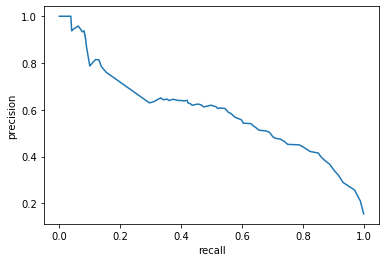

In [64]:
sns.lineplot(x="recall",
               y="precision",
               data=stats)

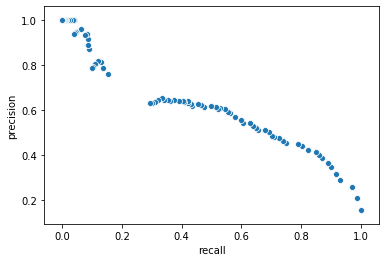

In [65]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [66]:
stats.iloc[0].num_true_positives / stats.iloc[0].num_predicted_positives

0.1544579321892005

In [67]:
base_precision = len(events_test[events_test["Ligand Confidence"] == "High"]) / len(events_train)
base_precision

0.015496852946786191

# Evaluate - Train Data

In [68]:
y_test = []
y_test_hat = []

In [69]:
for i, data in enumerate(train_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    print("Iteration: {}".format(i))
    x = data["x"]
    y = data["y"]
#     x = x.unsqueeze(1)
    y = y.view(-1,1)
    
    outputs = model(x)
    
    y_test.append(y.detach())
    y_test_hat.append(outputs.detach())
#     optimizer.zero_grad()
    gc.collect()

NameError: name 'train_dataloader' is not defined

In [ ]:
y = torch.cat(y_test)
y_hat = torch.cat(y_test_hat)

In [ ]:
# Get recall and precission for different cutoffs
points = []
for cutoff in np.linspace(0, 1, 50):
    precision = get_precision(y_hat, y, cutoff)
    recall = get_recall(y_hat, y, cutoff)
    points.append({"cutoff": cutoff,
                   "precision": precision, 
                   "recall":recall})

In [ ]:
stats = pd.DataFrame(points).set_index("cutoff")

In [ ]:
stats

In [ ]:
sns.lineplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
sns.scatterplot(x="recall",
               y="precision",
               data=stats,
            estimator=None)

In [ ]:
base_precision = len(events_train[events_train["ligand_confidence_inspect"] == "High"]) / len(events_train)
base_precision

In [ ]:
while True:
    time.sleep(60)

In [ ]:
torch.save(model.state_dict(), "model_params.pt")

# Inspect Model

In [ ]:
trace.history

In [ ]:
iterator = dataset.make_one_shot_iterator()

In [ ]:
x, y = iterator.next()

In [ ]:
x

In [ ]:
model.net(x)

In [ ]:
print(y)

In [ ]:
model.save_weights("model_32.h5")

In [ ]:
from torch.ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

In [ ]:
trainer = create_supervised_trainer(model, optimizer, loss)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def print